The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Máxima verossimilhança
:label:`sec_maximum_likelihood`

Uma das formas de pensar mais comumente encontradas no aprendizado de máquina é o ponto de vista de máxima verossimilhança. É o conceito de que ao trabalhar com um modelo probabilístico com parâmetros desconhecidos, os parâmetros que fazem os dados terem maior probabilidade são os mais prováveis.

## O Princípio da Máxima Verossimilhança

Isso tem uma interpretação bayesiana sobre a qual pode ser útil pensar. Suponha que tenhamos um modelo com parâmetros $\boldsymbol{\theta}$ e uma coleção de exemplos de dados $ X $. Para concretizar, podemos imaginar que $\boldsymbol{\theta}$ é um valor único que representa a probabilidade de que uma moeda dê cara quando lançada, e $X$ é uma sequência de lançamentos independentes de moedas. Veremos este exemplo em profundidade mais tarde.

Se quisermos encontrar o valor mais provável para os parâmetros do nosso modelo, isso significa que queremos encontrar

$$\mathop{\mathrm{argmax}} P(\boldsymbol{\theta}\mid X).$$
:eqlabel:`eq_max_like`

Pela regra de Bayes, isso é a mesma coisa que

$$
\mathop{\mathrm{argmax}} \frac{P(X \mid \boldsymbol{\theta})P(\boldsymbol{\theta})}{P(X)}.
$$

A expressão $P(X)$, um parâmetro de probabilidade agnóstica de gerar os dados, não depende de $\boldsymbol{\theta}$ e, portanto, pode ser descartada sem alterar a melhor escolha de $\boldsymbol{\theta}$. Da mesma forma, podemos agora postular que não temos nenhuma suposição anterior sobre qual conjunto de parâmetros é melhor do que qualquer outro, então podemos declarar que $P(\boldsymbol{\theta})$ também não depende de teta! Isso, por exemplo, faz sentido em nosso exemplo de cara ou coroa, onde a probabilidade de dar cara pode ser qualquer valor em $ [0,1] $ sem qualquer crença prévia de que seja justo ou não (muitas vezes referido como um *prévio não informativo*) Assim, vemos que nossa aplicação da regra de Bayes mostra que nossa melhor escolha de $\boldsymbol{\theta}$ é a estimativa de máxima verossimilhança para $\boldsymbol{\theta}$:

$$
\hat{\boldsymbol{\theta}} = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(X \mid \boldsymbol{\theta}).
$$

Como uma terminologia comum, a probabilidade dos dados dados os parâmetros ($P(X \mid \boldsymbol{\theta})$) é conhecida como *probabilidade*.

### Um exemplo concreto

Vamos ver como isso funciona em um exemplo concreto. Suponha que tenhamos um único parâmetro $\theta$ representando a probabilidade de cara ao cara. Então a probabilidade de obter uma coroa é $1-\theta$, e se nossos dados observados $X$ são uma sequência com $n_H$ cara e $n_T$ coroa, podemos usar o fato de que as probabilidades independentes se multiplicam para ver que

$$
P(X \mid \theta) = \theta^{n_H}(1-\theta)^{n_T}.
$$

Se lançarmos $13$ em moedas e obtivermos a sequência "HHHTHTTHHHHHT", que tem $n_H = 9$ e $n_T = 4$, vemos que isso é

$$
P(X \mid \theta) = \theta^9(1-\theta)^4.
$$

Uma coisa boa sobre esse exemplo é que sabemos qual será a resposta. Na verdade, se disséssemos verbalmente: "Joguei 13 moedas e deram cara com 9, qual é nossa melhor estimativa para a probabilidade de que a moeda nos dê cara? , "todos acertariam $9/13$. O que este método de máxima verossimilhança nos dará é uma maneira de obter esse número dos primeiros principais de uma forma que irá generalizar para situações muito mais complexas.

Para nosso exemplo, o gráfico de $P(X \mid \theta)$ é o seguinte:


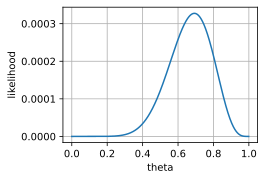

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

theta = torch.arange(0, 1, 0.001)
p = theta**9 * (1 - theta)**4.

d2l.plot(theta, p, 'theta', 'likelihood')

Isso tem seu valor máximo em algum lugar perto de nossos $9/13 \approx 0.7\ldots$. Para ver se está exatamente lá, podemos recorrer ao cálculo. Observe que, no máximo, a função é plana. Assim, poderíamos encontrar a estimativa de máxima verossimilhança :eqref:`eq_max_like` encontrando os valores de $\theta$ onde a derivada é zero, e encontrando aquele que dá a maior probabilidade. Calculamos:

$$
\begin{aligned}
0 & = \frac{d}{d\theta} P(X \mid \theta) \\
& = \frac{d}{d\theta} \theta^9(1-\theta)^4 \\
& = 9\theta^8(1-\theta)^4 - 4\theta^9(1-\theta)^3 \\
& = \theta^8(1-\theta)^3(9-13\theta).
\end{aligned}
$$

Isso tem três soluções: $0$, $1$ e $9/13$. Os dois primeiros são claramente mínimos, não máximos, pois atribuem probabilidade $0$ à nossa sequência. O valor final *não* atribui probabilidade zero à nossa sequência e, portanto, deve ser a estimativa de máxima verossimilhança $\hat \theta = 9/13$.

## Otimização Numérica e o Log-Probabilidade Negativa

O exemplo anterior é bom, mas e se tivermos bilhões de parâmetros e exemplos de dados.

Primeiro observe que, se fizermos a suposição de que todos os exemplos de dados são independentes, não podemos mais considerar a probabilidade em si na prática, pois ela é um produto de muitas probabilidades. Na verdade, cada probabilidade está em $[0,1]$, digamos tipicamente com um valor de cerca de $1/2$, e o produto de $(1/2)^{1000000000}$ está muito abaixo da precisão da máquina. Não podemos trabalhar com isso diretamente.

No entanto, lembre-se que o logaritmo transforma produtos em somas, caso em que

$$
\log((1/2)^{1000000000}) = 1000000000\cdot\log(1/2) \approx -301029995.6\ldots
$$

Esse número se encaixa perfeitamente até mesmo em um único float de $32$ bits de precisão. Assim, devemos considerar o *log-verossimilhança*, que é

$$
\log(P(X \mid \boldsymbol{\theta})).
$$

Como a função $x \mapsto \log(x)$ está aumentando, maximizar a verossimilhança é o mesmo que maximizar o log-verossimilhança. De fato, em :numref:`sec_naive_bayes` veremos esse raciocínio aplicado ao trabalhar com o exemplo específico do classificador Bayes ingênuo.

Frequentemente trabalhamos com funções de perda, onde desejamos minimizar a perda. Podemos transformar a probabilidade máxima na minimização de uma perda tomando $-\log(P(X \mid \boldsymbol{\theta}))$, que é o *log-verossimilhança negativo*.

Para ilustrar isso, considere o problema anterior de jogar a moeda e finja que não conhecemos a solução da forma fechada. Podemos calcular que

$$
-\log(P(X \mid \boldsymbol{\theta})) = -\log(\theta^{n_H}(1-\theta)^{n_T}) = -(n_H\log(\theta) + n_T\log(1-\theta)).
$$

Isso pode ser escrito em código e otimizado gratuitamente até mesmo para bilhões de cara ou coroa.


In [2]:
# Set up our data
n_H = 8675309
n_T = 25624

# Initialize our paramteres
theta = torch.tensor(0.5, requires_grad=True)

# Perform gradient descent
lr = 0.00000000001
for iter in range(10):
    loss = -(n_H * torch.log(theta) + n_T * torch.log(1 - theta))
    loss.backward()
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.grad.zero_()

# Check output
theta, n_H / (n_H + n_T)

(tensor(0.5017, requires_grad=True), 0.9970550284664874)

A conveniência numérica é apenas uma das razões pelas quais as pessoas gostam de usar probabilidades de log negativo. Na verdade, há várias razões pelas quais pode ser preferível.



A segunda razão pela qual consideramos a log-verossimilhança é a aplicação simplificada das regras de cálculo. Conforme discutido acima, devido às suposições de independência, a maioria das probabilidades que encontramos no aprendizado de máquina são produtos de probabilidades individuais.

$$
P(X\mid\boldsymbol{\theta}) = p(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta})\cdots p(x_n\mid\boldsymbol{\theta}).
$$

Isso significa que se aplicarmos diretamente a regra do produto para calcular uma derivada, obtemos

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{\theta}} P(X\mid\boldsymbol{\theta}) & = \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_1\mid\boldsymbol{\theta})\right)\cdot P(x_2\mid\boldsymbol{\theta})\cdots P(x_n\mid\boldsymbol{\theta}) \\
& \quad + P(x_1\mid\boldsymbol{\theta})\cdot \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_2\mid\boldsymbol{\theta})\right)\cdots P(x_n\mid\boldsymbol{\theta}) \\
& \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \vdots \\
& \quad + P(x_1\mid\boldsymbol{\theta})\cdot P(x_2\mid\boldsymbol{\theta}) \cdots \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{\theta})\right).
\end{aligned}
$$

Isso requer $n(n-1)$ multiplicações, junto com $(n-1)$ adições, então é o total do tempo quadrático nas entradas! Inteligência suficiente em termos de agrupamento reduzirá isso ao tempo linear, mas requer alguma reflexão. Para a probabilidade de log negativo, temos, em vez disso,

$$
-\log\left(P(X\mid\boldsymbol{\theta})\right) = -\log(P(x_1\mid\boldsymbol{\theta})) - \log(P(x_2\mid\boldsymbol{\theta})) \cdots - \log(P(x_n\mid\boldsymbol{\theta})),
$$

que então dá

$$
- \frac{\partial}{\partial \boldsymbol{\theta}} \log\left(P(X\mid\boldsymbol{\theta})\right) = \frac{1}{P(x_1\mid\boldsymbol{\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_1\mid\boldsymbol{\theta})\right) + \cdots + \frac{1}{P(x_n\mid\boldsymbol{\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{\theta})\right).
$$

Isso requer apenas $n$ divisões e $n-1$ somas e, portanto, é o tempo linear nas entradas.

A terceira e última razão para considerar o log-verossimilhança negativo é a relação com a teoria da informação, que discutiremos em detalhes em :numref:`sec_information_theory`. Esta é uma teoria matemática rigorosa que fornece uma maneira de medir o grau de informação ou aleatoriedade em uma variável aleatória. O principal objeto de estudo nesse campo é a entropia, que é

$$
H(p) = -\sum_{i} p_i \log_2(p_i),
$$

que mede a aleatoriedade de uma fonte. Observe que isso nada mais é do que a probabilidade média de $-\log$ e, portanto, se tomarmos nosso log de verossimilhança negativo e dividirmos pelo número de exemplos de dados, obteremos um relativo de entropia conhecido como entropia cruzada. Essa interpretação teórica por si só seria suficientemente atraente para motivar o relato da probabilidade logarítmica negativa média sobre o conjunto de dados como uma forma de medir o desempenho do modelo.

## Máxima probabilidade para variáveis contínuas

Tudo o que fizemos até agora assume que estamos trabalhando com variáveis aleatórias discretas, mas e se quisermos trabalhar com variáveis contínuas?

O breve resumo é que nada muda, exceto que substituímos todas as instâncias da probabilidade pela densidade de probabilidade. Lembrando que escrevemos densidades com $p$ minúsculo, isso significa que, por exemplo, agora dizemos

$$
-\log\left(p(X\mid\boldsymbol{\theta})\right) = -\log(p(x_1\mid\boldsymbol{\theta})) - \log(p(x_2\mid\boldsymbol{\theta})) \cdots - \log(p(x_n\mid\boldsymbol{\theta})) = -\sum_i \log(p(x_i \mid \theta)).
$$

A questão passa a ser: "Por que está tudo bem?" Afinal, a razão pela qual introduzimos densidades foi porque as probabilidades de obter resultados específicos eram zero e, portanto, a probabilidade de gerar nossos dados para qualquer conjunto de parâmetros não é zero?

Na verdade, esse é o caso, e entender por que podemos mudar para densidades é um exercício de rastrear o que acontece com os ípsilons.

Vamos primeiro redefinir nosso objetivo. Suponha que, para variáveis aleatórias contínuas, não desejemos mais calcular a probabilidade de obter exatamente o valor correto, mas, em vez disso, fazer a correspondência dentro de algum intervalo $\epsilon$. Para simplificar, assumimos que nossos dados são observações repetidas $x_1, \ldots, x_N$ de variáveis aleatórias distribuídas de forma idêntica $X_1, \ldots, X_N$. Como vimos anteriormente, isso pode ser escrito como

$$
\begin{aligned}
&P(X_1 \in [x_1, x_1+\epsilon], X_2 \in [x_2, x_2+\epsilon], \ldots, X_N \in [x_N, x_N+\epsilon]\mid\boldsymbol{\theta}) \\
\approx &\epsilon^Np(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta}) \cdots p(x_n\mid\boldsymbol{\theta}).
\end{aligned}
$$

Assim, se tomarmos logaritmos negativos disso, obtemos

$$
\begin{aligned}
&-\log(P(X_1 \in [x_1, x_1+\epsilon], X_2 \in [x_2, x_2+\epsilon], \ldots, X_N \in [x_N, x_N+\epsilon]\mid\boldsymbol{\theta})) \\
\approx & -N\log(\epsilon) - \sum_{i} \log(p(x_i\mid\boldsymbol{\theta})).
\end{aligned}
$$

Se examinarmos esta expressão, o único lugar onde o $\epsilon$ ocorre é na constante aditiva $ -N \ log (\ epsilon) $. Isso não depende dos parâmetros $\boldsymbol{\theta}$ de forma alguma, então a escolha ótima de $\boldsymbol{\theta}$ não depende de nossa escolha de $\epsilon$! Se exigirmos quatro dígitos ou quatrocentos, a melhor escolha de $\boldsymbol{\theta}$ permanece a mesma, portanto, podemos descartar livremente o ípsilon para ver que o que queremos otimizar é

$$
- \sum_{i} \log(p(x_i\mid\boldsymbol{\theta})).
$$


Assim, vemos que o ponto de vista de máxima verossimilhança pode operar com variáveis aleatórias contínuas tão facilmente quanto com variáveis discretas, substituindo as probabilidades por densidades de probabilidade.

## Resumo
* O princípio de máxima verossimilhança nos diz que o modelo de melhor ajuste para um determinado conjunto de dados é aquele que gera os dados com a maior probabilidade.
* Freqüentemente, as pessoas trabalham com a probabilidade logarítmica negativa por uma variedade de razões: estabilidade numérica, conversão de produtos em somas (e a simplificação resultante dos cálculos de gradiente) e vínculos teóricos com a teoria da informação.
* Embora seja mais simples de motivar na configuração discreta, pode ser generalizado livremente para a configuração contínua, bem como maximizando a densidade de probabilidade atribuída aos pontos de dados.

## Exercícios

1. Suponha que você saiba que uma variável aleatória tem densidade $\frac{1}{\alpha}e^{-\alpha x}$ para algum valor $\alpha$. Você obtém uma única observação da variável aleatória que é o número $3$. Qual é a estimativa de máxima verossimilhança para $\alpha$?
2. Suponha que você tenha um conjunto de dados de amostras $\{x_i\}_{i=1}^N$ extraído de um Gaussiano com média desconhecida, mas variância $1$. Qual é a estimativa de máxima verossimilhança para a média?


[Discussão](https://discuss.d2l.ai/t/1096)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTE4MDkxMTg4NywxMDk4NDE1MzU1LC0zNz
k0OTkxNDYsMTg5MDkwNzg2OV19
-->
